In [119]:
from config import *
import warnings
warnings.filterwarnings('ignore')

# 0. Data

In [120]:
df_base = pd.read_csv('data/italian_stock_data_2004_2024.csv', index_col=0, header=[0,1])
df_base = df_base.stack(level='Ticker').reset_index()
df_base.fillna(method='ffill', inplace=True) 
df_base.Date = pd.to_datetime(df_base.Date)
df_base.rename(columns={col:col.lower() for col in df_base.columns}, inplace=True)
df_base.rename(columns={'adj close':'adj_close'}, inplace=True)
df_base.ticker = df_base.ticker.str.replace('.MI','').str.replace('1','')

Feature engineering

In [121]:
# Basic Features
df_base['daily_return'] = df_base.groupby('ticker')['adj_close'].pct_change()
df_base['price_range'] = df_base['high'] - df_base['low']

# Moving Averages
df_base['sma_20'] = df_base.groupby('ticker')['adj_close'].rolling(window=20).mean().reset_index(0, drop=True)
df_base['sma_50'] = df_base.groupby('ticker')['adj_close'].rolling(window=50).mean().reset_index(0, drop=True)
df_base['ema_20'] = df_base.groupby('ticker', group_keys=False)['adj_close'].apply(lambda x: x.ewm(span=20, adjust=False).mean())

# Volatility Features
df_base['volatility_20'] = df_base.groupby('ticker')['adj_close'].rolling(window=20).std().reset_index(0, drop=True)
df_base['bollinger_upper'] = df_base['sma_20'] + 2 * df_base['volatility_20']
df_base['bollinger_lower'] = df_base['sma_20'] - 2 * df_base['volatility_20']

# Momentum Indicators
delta = df_base.groupby('ticker')['adj_close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
df_base['rsi'] = 100 - (100 / (1 + gain / loss))
df_base['macd'] = df_base.groupby('ticker', group_keys=False)['adj_close'].apply(
    lambda x: x.ewm(span=12, adjust=False).mean() - x.ewm(span=26, adjust=False).mean()
).reset_index(level=0, drop=True)
df_base['signal'] = df_base['macd'].ewm(span=9, adjust=False).mean()

# Volume Features
df_base['volume_sma_20'] = df_base.groupby('ticker')['volume'].rolling(window=20).mean().reset_index(0, drop=True)
#df_base['volume_spike'] = df_base['volume'] > 2 * df_base['volume_sma_20']

# Custom Features for GP
df_base['open_close_ratio'] = df_base['open'] / df_base['close']
df_base['high_low_ratio'] = df_base['high'] / df_base['low']
#df_base['day_of_week'] = pd.to_datetime(df_base['date']).dt.dayofweek
df_base['cumulative_return'] = (1 + df_base['daily_return']).groupby(df_base['ticker']).cumprod()

In [122]:
df_base.sort_values(['ticker','date'], inplace=True)
df_base.set_index('date', inplace=True)
df_base['year'] = df_base.index.year
df_base['month'] = df_base.index.to_period('M').to_timestamp()

In [123]:
features = ['adj_close', 'close', 'high', 'low', 'open', 'volume',
       'daily_return', 'price_range', 'sma_20', 'sma_50', 'ema_20',
       'volatility_20', 'bollinger_upper', 'bollinger_lower', 'rsi', 'macd',
       'signal', 'volume_sma_20', 'open_close_ratio',
       'high_low_ratio', 'cumulative_return']

In [124]:
def standardize_features(group_df):
    for feature in features:
        group_df[feature] = (
            group_df[feature] - group_df[feature].mean()
        ) / group_df[feature].std()
    return group_df

In [125]:
df = df_base.groupby('ticker', group_keys=False).apply(standardize_features)
#df['adj_close_orig'] = df_base['adj_close']
df = df.dropna()
df = df[~df.ticker.isin(['LDO','MONC','PIRC','PRY','PST'])] # these stocks appear later in the data, we want to start running the algorithm from 2004
df

Price,ticker,adj_close,close,high,low,open,volume,daily_return,price_range,sma_20,...,bollinger_lower,rsi,macd,signal,volume_sma_20,open_close_ratio,high_low_ratio,cumulative_return,year,month
date,,,,,,,,,,,,,,,,,,,,,
2004-03-10 00:00:00+00:00,A2A,-0.733183,0.271483,0.286225,0.285612,0.317797,-0.923188,-0.715508,0.136278,-0.750584,...,-0.701981,0.188346,0.288471,0.352079,-1.523189,0.883551,-0.146328,-0.733323,2004,2004-03-01
2004-03-11 00:00:00+00:00,A2A,-0.771611,0.204841,0.238975,0.208812,0.270181,-0.793142,-1.251627,0.897880,-0.750861,...,-0.702676,-0.668306,0.192870,0.392050,-1.496860,1.285478,0.558908,-0.771749,2004,2004-03-01
2004-03-12 00:00:00+00:00,A2A,-0.782589,0.185800,0.182274,0.132012,0.174950,-0.889592,-0.380966,1.405619,-0.750861,...,-0.702676,-1.413255,0.097713,0.383032,-1.473887,-0.238113,1.074767,-0.782728,2004,2004-03-01
2004-03-15 00:00:00+00:00,A2A,-0.804548,0.147719,0.172824,0.160812,0.174950,-0.985167,-0.745276,0.390142,-0.752246,...,-0.708055,-1.375669,-0.012989,0.351354,-1.457927,0.535766,0.145312,-0.804686,2004,2004-03-01
2004-03-16 00:00:00+00:00,A2A,-0.816625,0.126774,0.133134,0.135852,0.119716,-1.017320,-0.424880,-0.016050,-0.754240,...,-0.715962,-1.413255,-0.119331,0.160064,-1.446432,-0.163896,-0.202684,-0.816763,2004,2004-03-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-21 00:00:00+00:00,UCG,-0.375302,-0.525852,-0.531877,-0.521731,-0.528314,-0.840307,-0.015819,-0.701834,-0.360223,...,-0.327368,0.441928,0.037390,0.474876,-0.204950,-0.212031,-0.808740,-0.375121,2023,2023-12-01
2023-12-22 00:00:00+00:00,UCG,-0.372973,-0.524343,-0.532532,-0.520210,-0.525863,-0.912924,0.095814,-0.783210,-0.361243,...,-0.328629,0.606483,0.031644,0.488487,-0.222503,-0.129531,-1.006864,-0.372791,2023,2023-12-01
2023-12-27 00:00:00+00:00,UCG,-0.372099,-0.523777,-0.529819,-0.519164,-0.524261,-0.958765,0.030017,-0.719524,-0.361745,...,-0.329499,0.974695,0.029707,0.500576,-0.249726,-0.039342,-0.854408,-0.371918,2023,2023-12-01


In [126]:
ticker_symbols = df.ticker.unique()

# 1. Portfolio selection using GP

## Baseline: Markowitz

In [127]:
def create_portfolio_markowitz_wrapper(df_reference):
    df_mark =  df_reference.pivot(columns='ticker', values='adj_close')
    num_stocks = len(df_mark.columns)
    avg_returns = np.array([np.mean(df_mark[col]) for col in df_mark.columns]).reshape(num_stocks,1)
    cov_matrix = np.matrix(df_mark.cov())
    optimal_weights_markowitz, _ = markowitz_solution(num_stocks,
                                                        avg_returns,
                                                        cov_matrix,
                                                        risk_aversion=0.5,
                                                        short_selling=False)
    return optimal_weights_markowitz.reshape((12,))

## Genetic programming

In [128]:
# Parameters for genetic programming
POPULATION_SIZE = 10
GENERATIONS = 20
TOURNAMENT_SIZE = 3
MUTATION_RATE = 0.1

In [129]:
def generate_random_strategy():
    """Generate a random strategy as a simple decision rule."""
    return {
        "threshold": np.random.normal(loc=0, scale=1), # all features have been standardized
        "feature": random.choice(features),
        "type": random.choice(["momentum", "contrarian"]),
    }

In [130]:
def create_portfolio(strategy, df_reference):
    buy_intensities = []
    for ticker in ticker_symbols:
        if strategy["type"] == "momentum":
            buy_intensities.append(df_reference[df_reference.ticker==ticker][strategy["feature"]].iloc[0] - strategy["threshold"])
        elif strategy["type"] == "contrarian":
            buy_intensities.append(strategy["threshold"] - df_reference[df_reference.ticker==ticker][strategy["feature"]].iloc[0])
    buy_intensities_rescaled = np.array(buy_intensities) + abs(min(np.array(buy_intensities))) * (min(np.array(buy_intensities)) < 0) # ensure all elements are above 0, no short selling
    portfolio_weights = np.array(buy_intensities_rescaled) / sum(buy_intensities_rescaled)
    return portfolio_weights

In [131]:
def evaluate_portfolio(portfolio_weights, df_reference):
    portfolio_value = np.dot(portfolio_weights,df_reference['adj_close'])
    return portfolio_value

### GP operators

In [132]:
def select_parent(population, fitnesses):
    """Select a parent using tournament selection."""
    tournament = random.sample(list(zip(population, fitnesses)), TOURNAMENT_SIZE)
    return max(tournament, key=lambda x: x[1])[0]

In [133]:
def crossover_strategy(parent1, parent2):
    """Combine two parent strategies to create an offspring."""
    return {
        "threshold": random.choice([parent1["threshold"], parent2["threshold"]]),
        "feature": random.choice([parent1["feature"], parent2["feature"]]),
        "type": random.choice([parent1["type"], parent2["type"]]),
    }

In [134]:
def mutate_strategy(strategy):
    """Randomly modify the strategy to introduce variation."""
    if random.random() < MUTATION_RATE:
        strategy["threshold"] += random.uniform(-0.5, 0.5)
    if random.random() < MUTATION_RATE:
        strategy["feature"] = random.choice(features)
    if random.random() < MUTATION_RATE:
        strategy["type"] = "momentum" if strategy["type"] == "contrarian" else "contrarian"
    return strategy

### GP loop

In [135]:
population = [generate_random_strategy() for _ in range(POPULATION_SIZE)]

for year in range(2005,2019):

    # get prices - the prices of this year
    df_train = df[df.year==year-1].groupby('ticker').mean()[features].reset_index()
    df_test = df[df.year==year].groupby('ticker').mean()[features].reset_index()
    portfolios = [create_portfolio(strategy, df_train) for strategy in population]

    for generation in range(GENERATIONS):
        # Evaluate fitness (portfolio value)
        fitnesses = [evaluate_portfolio(portfolio, df_test) for portfolio in portfolios]

        # Create new population
        new_population = []
        
        for _ in range(POPULATION_SIZE):
            
            # Select parents
            parent1 = select_parent(population, fitnesses)
            parent2 = select_parent(population, fitnesses)

            # Create offspring
            offspring = crossover_strategy(parent1, parent2)
            offspring = mutate_strategy(offspring)

            new_population.append(offspring)

        population = new_population

In [136]:
population[0]

{'threshold': -0.39804176916575085, 'feature': 'rsi', 'type': 'momentum'}

# 2. Plots

In [137]:
df_train_final = df[df.year<=2018].groupby('ticker').mean()[features].reset_index()
df_test_final = df[df.year>2018].groupby('ticker').mean()[features].reset_index()

In [138]:
final_population = []
for strategy in population:
    if strategy not in final_population:
        final_population.append(strategy) # killing off duplicates

In [139]:
final_performances = [(strategy,evaluate_portfolio(create_portfolio(strategy, df_train_final), df_test_final)) for strategy in final_population]
best_strategies = [tup[0] for tup in sorted(final_performances, key=lambda x: x[1], reverse=True)[:3]]
best_strategies

[{'threshold': -0.39804176916575085,
  'feature': 'price_range',
  'type': 'contrarian'},
 {'threshold': -0.5438250362731479, 'feature': 'ema_20', 'type': 'contrarian'},
 {'threshold': -0.39804176916575085, 'feature': 'rsi', 'type': 'momentum'}]

In [140]:
def groupby_portfolio_month(month):
    return df[df.month==month].groupby('ticker').mean()[features].reset_index()

In [141]:
months = df[df.year>=2019].sort_values('month').month.unique()

In [142]:
portfolio_values_markowitz = [evaluate_portfolio(
                                create_portfolio_markowitz_wrapper(
                                    df[df.month==previous_month]
                                    ),
                                groupby_portfolio_month(month)
                                ) for previous_month,month in zip(months[:-1],months[1:])]
portfolio_values_strategy_1 = [evaluate_portfolio(
                                create_portfolio(
                                    best_strategies[0],
                                    groupby_portfolio_month(previous_month)
                                    ),
                                groupby_portfolio_month(month)
                                ) for previous_month,month in zip(months[:-1],months[1:])]
portfolio_values_strategy_2 = [evaluate_portfolio(
                                create_portfolio(
                                    best_strategies[1],
                                    groupby_portfolio_month(previous_month)
                                    ),
                                groupby_portfolio_month(month)
                                ) for previous_month,month in zip(months[:-1],months[1:])]
portfolio_values_strategy_3 = [evaluate_portfolio(
                                create_portfolio(
                                    best_strategies[2],
                                    groupby_portfolio_month(previous_month)
                                    ),
                                groupby_portfolio_month(month)
                                ) for previous_month,month in zip(months[:-1],months[1:])]

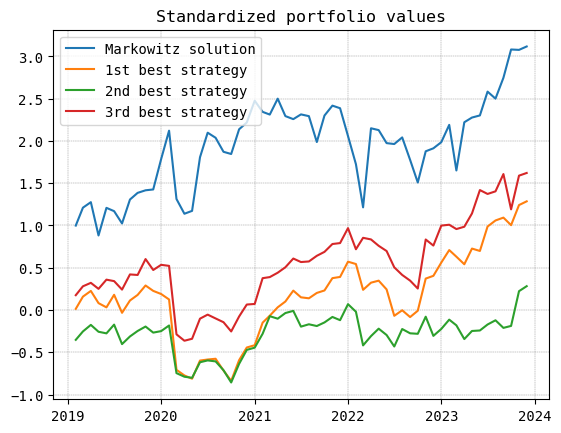

In [143]:
plt.plot(months[1:], 
         portfolio_values_markowitz,
         label='Markowitz solution')
plt.plot(months[1:], 
         portfolio_values_strategy_1,
         label='1st best strategy')
plt.plot(months[1:], 
         portfolio_values_strategy_2,
         label='2nd best strategy')
plt.plot(months[1:], 
         portfolio_values_strategy_3,
         label='3rd best strategy')
plt.title('Standardized portfolio values')
plt.legend()
plt.savefig('out/GP/Portfolio evolution - Markowitz vs GP.png')